# EXPERIMENTAL: SPSB qujax demo

Note that this feature is experimental and not sufficiently tested. Jitting is not supported by qujax currently.

## Initialise simple parametrised circuit

In [1]:
from __future__ import annotations

from jax import numpy as jnp
import qujax

circuit_gates = ['H', 'Ry', 'CZ']
circuit_qubit_inds = [[0], [0], [0, 1]]
circuit_params_inds = [[], [0], []]

qujax.print_circuit(circuit_gates, circuit_qubit_inds, circuit_params_inds);

q0: -----H-----Ry[0]-----◯---
                         |   
q1: ---------------------CZ--


In [2]:
# Get fuction that maps parameters to state vector
param_to_st = qujax.get_params_to_statetensor_func(circuit_gates,
                                                   circuit_qubit_inds,
                                                   circuit_params_inds)
param_to_st(jnp.array([0.5]))

DeviceArray([[0.        +0.j, 0.        +0.j],
             [0.99999994+0.j, 0.        +0.j]], dtype=complex64)

In [3]:
# Get function that maps state vector to expectation value
st_to_expectation = qujax.get_statetensor_to_expectation_func([['Z']], [[0]], [1.])

In [4]:
from jax import value_and_grad

param_to_expectation = lambda param: st_to_expectation(param_to_st(param))
expectation_and_grad = value_and_grad(param_to_expectation)
expectation_and_grad(jnp.array([0.1]))

(DeviceArray(-0.3090171, dtype=float32),
 DeviceArray([-2.987832], dtype=float32))

## Define custom gradient in jax

In [5]:
### custom gradient in jax

import jax.numpy as jnp
from jax import custom_jvp, random
from functools import partial

@partial(custom_jvp, nondiff_argnums=(0, 2, 3))
def jax_spsa(f, x, key, epsilon = 0.01):
  return f(x)

@jax_spsa.defjvp
def jax_spsa_jvp(f, key, epsilon, primals, tangents):
    x, = primals
    x_dot, = tangents
    shifts = random.randint(key, (len(x),), 0, 2) * 2 - 1
    x_plus, x_minus = x + epsilon * shifts, x - epsilon * shifts
    jacobian = jnp.outer(f(x_plus) - f(x_minus), 1 / (2 * epsilon * shifts))
    jvp = jnp.einsum("mn,n -> m", jacobian, x_dot)
    if jvp.shape == (1,):
        jvp = jvp[0]
    return f(x), jvp

In [6]:
from jax import value_and_grad, jit

g = lambda x, key: jax_spsa(param_to_expectation, x, key)
grad_f = jit(value_and_grad(g))

key = random.PRNGKey(0)
grad_f(jnp.array([0.1]), key)

(DeviceArray(-0.3090171, dtype=float32),
 DeviceArray([-2.987343], dtype=float32))

In [7]:
%%timeit
grad_f(jnp.array([0.1]), key)

86.5 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Full hybrid pipeline

In [8]:
## define input layer with tket
import pytket
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter

N_FEATURES = 10
input_circuit = pytket.Circuit(N_FEATURES)
syms = symbols('x0:{}'.format(N_FEATURES))
for i in range(N_FEATURES):
    input_circuit.Rx(syms[i], i)
inp_symbols = list(input_circuit.free_symbols())
input_circuit

[Rx(x0) q[0]; Rx(x1) q[1]; Rx(x2) q[2]; Rx(x3) q[3]; Rx(x4) q[4]; Rx(x5) q[5]; Rx(x6) q[6]; Rx(x7) q[7]; Rx(x8) q[8]; Rx(x9) q[9]; ]

In [9]:
## define PQC layer with tket
N_LAYERS = 3

pqc_circuit = pytket.Circuit(N_FEATURES)
for i in range(N_LAYERS):
    for j in range(N_FEATURES):
        pqc_circuit.H(j)
    syms = symbols('x{}_:{}'.format(i, N_FEATURES))
    for j in range(N_FEATURES):
        pqc_circuit.CRz(syms[j], j, (j+1) % N_FEATURES)
pqc_symbols = list(pqc_circuit.free_symbols())
render_circuit_jupyter(pqc_circuit)

In [10]:
# convert to qujax circuit
from pytket.extensions.qujax import tk_to_qujax

qjax_inp = tk_to_qujax(input_circuit)
qjax_pqc = tk_to_qujax(pqc_circuit)
exp_val = lambda i: qujax.get_statetensor_to_expectation_func([['Z']], [[i]], [1.])

## Define sequence model

In [11]:
# Define model forward pass as function of parameters
import jax

def neural_network(inp: jnp.ndarray, weights: jnp.ndarray, bias: jnp.ndarray):
    return  jnp.dot(inp, weights) + bias

def evaluate_pqc(params: tuple[jnp.ndarray], state_in: jnp.ndarray):
    state = qjax_pqc(params, statetensor_in = state_in)
    return jnp.array([exp_val(i)(state) for i in range(N_FEATURES)])

def forward_pass(inp: jnp.ndarray, params: tuple[jnp.ndarray], key: random.PRNGKey):
    pqc_params, weights, bias = params
    exp = jax_spsa(lambda x: evaluate_pqc(x, qjax_inp(inp)), pqc_params, key)
    return jax.nn.sigmoid(neural_network(exp, weights, bias)).squeeze()

def bce_loss(y_pred: jnp.ndarray, y_true: jnp.ndarray):
    return -jnp.mean(y_true * jnp.log(y_pred) + (1 - y_true) * jnp.log(1 - y_pred))

In [12]:
# init weights and bias
initialiser = jax.nn.initializers.xavier_uniform()
seed = jax.random.PRNGKey(42)
weights = initialiser(seed, shape=(N_FEATURES, 1)).reshape(-1)
bias = initialiser(seed, shape=(1,1)).reshape(-1)

# init pqc params
pqc_params = jnp.array([0.1] * len(pqc_symbols))

# init random data point
X = jnp.array([jnp.arange(1,N_FEATURES+1)/10, - jnp.arange(11,N_FEATURES+11)/10])
print(X)

key = random.PRNGKey(0)
forward_pass(X[0], (pqc_params, weights, bias), key)

[[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [-1.1 -1.2 -1.3 -1.4 -1.5 -1.6 -1.7 -1.8 -1.9 -2. ]]


DeviceArray(0.42407614, dtype=float32)

## Batch forward pass using vmap

In [13]:
from jax import vmap, jit

batched_forward = vmap(forward_pass, in_axes=(0, None, 0))

def loss(params: tuple[jnp.ndarray], x: jnp.ndarray, y: jnp.ndarray, keys):
    return bce_loss(batched_forward(x, params, keys), y)

keys = random.split(random.PRNGKey(0), X.shape[0])
loss((pqc_params, weights, bias), X, jnp.array([1, 0]), keys)

DeviceArray(0.7256458, dtype=float32)

In [14]:
# differentiate forward pass
from jax import grad, value_and_grad

# differentiate loss function
loss_diff = value_and_grad(loss)

In [15]:

grads = loss_diff((pqc_params, weights, bias), X, jnp.array([1, 0]), keys)
grads

(DeviceArray(0.7256458, dtype=float32),
 (DeviceArray([-0.2335245 ,  0.2335245 , -0.00825837,  0.2335245 ,
               -0.2335245 , -0.00825837,  0.2335245 , -0.2335245 ,
               -0.2335245 ,  0.2335245 , -0.00825837,  0.00825837,
                0.00825837, -0.00825837, -0.00825837,  0.2335245 ,
                0.00825837,  0.2335245 ,  0.00825837, -0.2335245 ,
               -0.2335245 ,  0.00825837, -0.00825837, -0.00825837,
                0.00825837,  0.2335245 ,  0.00825837, -0.00825837,
               -0.2335245 , -0.2335245 ], dtype=float32),
  DeviceArray([-0.02162373,  0.05224387,  0.05086371,  0.02579836,
               -0.01278259, -0.04925536, -0.06854713, -0.061941  ,
               -0.03051314,  0.01311487], dtype=float32),
  DeviceArray([-0.06417122], dtype=float32)))

In [16]:
## dummy training loop on one data point

EPOCHS = 100
lr = 0.05

params = (pqc_params, weights, bias)
keys = random.split(random.PRNGKey(0), 2)
for i in range(EPOCHS):
    l, g = loss_diff(params, X, jnp.array([1, 0]), keys)
    params = tuple([p - lr * dp for p, dp in zip(params, g)])
    if i % 10 == 0:
        print(l)
    keys = random.split(keys[0], 2)

0.7256458
0.58034253
0.51091456
0.43540257
0.3663059
0.31270742
0.27715456
0.25229633
0.2213174
0.19839826


In [17]:
print(batched_forward(X, params, keys))

[0.8349771  0.14854519]


In [18]:
print(params[0])

[ 0.23745587 -0.45759943 -0.0345304   0.02349326  0.2759504  -0.11696441
 -0.06281582  0.03283886 -0.18145162  0.46764454  0.00294022  0.61014235
 -0.22740027 -0.16985571  0.24884239 -0.79263437 -0.13080326 -0.15817292
  0.38816682  0.5107782   0.28632364  0.49459812  0.12075303  0.21502972
  0.3059354   0.31343707  0.22958006 -0.147616   -0.04843996  0.28400984]


## Train model on random Dataset

In [19]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

N_SAMPLES = 100

X, Y = make_classification(N_SAMPLES, n_features=N_FEATURES)
# scale X to [0,2]
X = MinMaxScaler((0,2)).fit_transform(X)
X = X.tolist()
Y = Y.tolist()

# init weights and bias
initialiser = jax.nn.initializers.xavier_uniform()
seed = jax.random.PRNGKey(42)
weights = initialiser(seed, shape=(N_FEATURES, 1)).squeeze()
bias = initialiser(seed, shape=(1,1)).squeeze()

# init pqc params
pqc_params = jnp.array([0.001] * len(pqc_symbols))

In [20]:
from jax.example_libraries.optimizers import adam
from lambeq import Dataset
from time import time

opt_init, opt_update, get_params = adam(1e-2)
opt_state = opt_init((pqc_params, weights, bias))

## init data loader
BATCH_SIZE = 10
dataset = Dataset(X, Y, batch_size=BATCH_SIZE)

EPOCHS = 100

step = 0
keys = random.split(random.PRNGKey(0), BATCH_SIZE)
loss = []
for epoch in range(EPOCHS):
  epoch_loss = 0
  for x, y in dataset:
    keys = random.split(keys[0], len(x))
    x, y = jnp.array(x), jnp.array(y)
    value, grads = loss_diff(get_params(opt_state), x, y, keys)
    opt_state = opt_update(step, grads, opt_state)
    epoch_loss += len(y)*value
    step += 1
  loss.append(epoch_loss / len(dataset))
  if epoch % 10 == 0:
    print('loss: ', loss[-1])
print('Final loss: ', loss[-1])

/home/thoffmann/Constant-Scaling-Quantum-Gradient-Estimation/venv_qjx/lib/python3.8/site-packages/lambeq/text2diagram/ccg_parser.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


loss:  0.69414634
loss:  0.46984994
loss:  0.38693568
loss:  0.3394263
loss:  0.3143958
loss:  0.30154392
loss:  0.28563365
loss:  0.2764777
loss:  0.267619
loss:  0.26743972
Final loss:  0.26826015


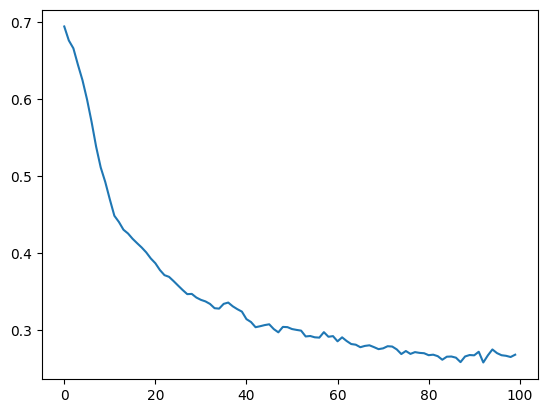

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss);